In [60]:
#Libraries will be imported here
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import utils
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.preprocessing.
from IPython.display import SVG, Image
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.2.0


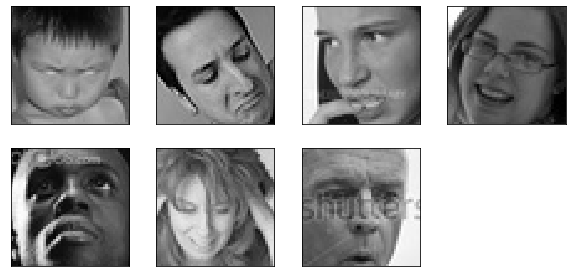

In [34]:
#Plotting images in each category for the Training Data
TrainSampleImagesOfEachCategory=[]
for directory in os.listdir('train'):
    TrainSampleImagesOfEachCategory.append('train/'+str(directory)+'/'+str(os.listdir('train/'+directory)[0]))
#for path in TrainSampleImagesOfEachCategory:
#    print(path)
plt.figure(figsize=(10,10))
for i in range(7):
    plt.subplot(4,4,i+1) 
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img=load_img(TrainSampleImagesOfEachCategory[i])
    plt.imshow(img)

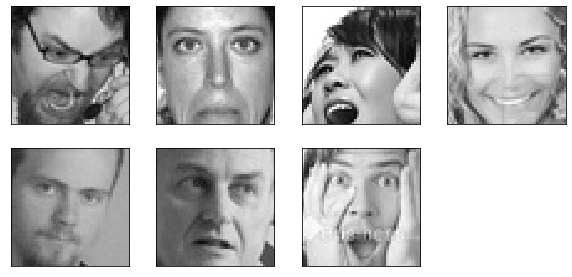

In [36]:
#Plotting image of each category in the Training Data
TestSampleImagesOfEachCategory=[]
for directory in os.listdir('test'):
    TestSampleImagesOfEachCategory.append('test/'+str(directory)+'/'+str(os.listdir('test/'+str(directory))[0]))

plt.figure(figsize=(10,10))
for i in range(7):
    plt.subplot(4,4,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img=load_img(TestSampleImagesOfEachCategory[i])
    plt.imshow(img)

In [39]:
#Checking the number of images in each category, if some of them are very low we perform Image Augmentation
#We could provide a class_weights argument in model.fit to account for classImbalance
for directory in os.listdir('train'):
    print(str(len(os.listdir('train/'+str(directory))))+' images in '+str(directory)+' category')
#Clearly Images of the disgust category are very low and hence we perform Image Augmentation on it.

3995 images in angry category
436 images in disgust category
4097 images in fear category
7215 images in happy category
4965 images in neutral category
4830 images in sad category
3171 images in surprise category


In [40]:
#Generating the training and validation sets
img_size=48
batch_size=64

datagen_train=ImageDataGenerator(horizontal_flip=True,
                                rescale=1/255)
train_generator=datagen_train.flow_from_directory('train',
                                                 target_size=(img_size,img_size),
                                                 color_mode='grayscale',
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

datagen_validation=ImageDataGenerator(horizontal_flip=True,
                                     rescale=1/255)
validation_generator=datagen_validation.flow_from_directory('test',
                                                           target_size=(img_size,img_size),
                                                           color_mode='grayscale',
                                                           batch_size=batch_size,
                                                           class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [48]:
dropout=0.25


model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(64,(3,3),padding='same',input_shape=(48,48,1)),#Note that we have grayscale images 
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(128,(5,5),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(512,(3,3),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Conv2D(512,(3,3),padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(7,activation='softmax')
])


opt=tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_31 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
activation_31 (Activation)   (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_32 (Batc (None, 24, 24, 128)      

In [52]:
#StepsPerEpoch=totalNoOfExamplesInTheGenerator//BatchSize
#.n gives the number of examples in the imageGenerator, .batch_size gives the batch size
epochs=15
training_steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps_per_epoch=validation_generator.n//validation_generator.batch_size

In [57]:
#Callbacks
#We set a checkpoint callback, to save the model weights with highest accuracy while we keep on training
#We also define a callback to reduce the learning rate when the validation plateaus out

checkpoint = tf.keras.callbacks.ModelCheckpoint('model_weights.h5',monitor='val_accuracy',
                                             save_weights_only=True,mode='max',verbose=1) #Mode argument means we want to save the weights with maximum val_accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                                patience=2,min_lr=0.00001,mode='auto') #Here the factor means by what factor do we want to reduce the learning rate
                                                #patience means that if for 2 epochs the val_loss doesn't changes we reduce the lr, min_lr means that this is the minimum the learning rate can get
callbacks=[checkpoint,reduce_lr]

history=model.fit(train_generator,steps_per_epoch=training_steps_per_epoch,
                 epochs=epochs,
                 validation_data=validation_generator,
                 validation_steps=validation_steps_per_epoch,
                 callbacks=callbacks)



Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.8112 - accuracy: 0.3081
Epoch 00001: saving model to model_weights.h5
448/448 [==============================] - 1177s 3s/step - loss: 1.8112 - accuracy: 0.3081 - val_loss: 1.7739 - val_accuracy: 0.2919 - lr: 5.0000e-04
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.4783 - accuracy: 0.4346
Epoch 00002: saving model to model_weights.h5
448/448 [==============================] - 1103s 2s/step - loss: 1.4783 - accuracy: 0.4346 - val_loss: 1.3487 - val_accuracy: 0.4780 - lr: 5.0000e-04
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.3307 - accuracy: 0.4912
Epoch 00003: saving model to model_weights.h5
448/448 [==============================] - 989s 2s/step - loss: 1.3307 - accuracy: 0.4912 - val_loss: 1.3171 - val_accuracy: 0.4888 - lr: 5.0000e-04
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.2442 - accuracy: 0.5267
Epoch 00004: saving model to 

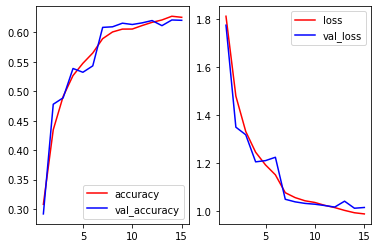

In [59]:
accuracy=history.history['accuracy']
loss=history.history['loss']
val_accuracy=history.history['val_accuracy']
val_loss=history.history['val_loss']
epochs=range(1,len(accuracy)+1)
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].plot(epochs,accuracy,color='red',label='accuracy')
ax[0].plot(epochs,val_accuracy,color='blue',label='val_accuracy')
ax[0].legend()
ax[1].plot(epochs,loss,color='red',label='loss')
ax[1].plot(epochs,val_loss,color='blue',label='val_loss')
ax[1].legend()

In [58]:
#Representing the model as a JSON string(It's like saving the model architechture)
model_json=model.to_json()
with open('model.json','w') as json_file:
    json_file.write(model_json)